<h1>Preprocessing </h1>

In [4]:
import tensorflow as tf
import cv2
import numpy as np
import os

In [5]:

# This function preprocesses the image by reading in the image apply grayscale make all the sizes the same and 
def preprocess_image(file_path, img_size):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Grayscale will even the playing field if we start getting different types of images. If the images color is a factor we can take out grayscale
    img = cv2.resize(img, img_size)
    img = img.astype('float')/255.0 # Make the pixels become float and normalize to 0-1 for normalization
    
    return img

# This function will pull from the directory and all subdirectory for the image and give it a label to the directory it is in
def load_images_from_directory(directory, target_size =(224, 224)):
    images = []
    labels = []
    
    # Iterates through all subdirectories
    for subdir in os.listdir(directory):
        label = subdir #Make the subdirectory name be a label
        subdir_path = os.path.join(directory, subdir)

        # Checks if the object it is looking at is a directory and if it is go into the directory and get all the files and preprocess them
        if os.path.isdir(subdir_path):
            for image in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, image)

                image = preprocess_image(file_path, target_size)
            
                # Append to the arrays after preprocessing
                images.append(image)
                labels.append(label)
        

    return np.array(images), np.array(labels)




In [6]:
# import sys # for debugging 

# Define the directory paths for the training and test datasets
train_dir = "./Alzheimer_s Dataset/train"
test_dir = "./Alzheimer_s Dataset/test"

# Load images and labels from the training directory
alz_images_train, alz_labels_train = load_images_from_directory(train_dir)

# Load images and labels from the test directory
alz_images_test, alz_labels_test = load_images_from_directory(test_dir)

# Print information about the training dataset
print("Train")
print('Image shape:', alz_images_train.shape)
print('Labels shape:', alz_labels_train.shape)

# Print information about the test dataset
print("\nTest")
print('Image shape:', alz_images_test.shape)
print('Labels shape:', alz_labels_test.shape)


# np.set_printoptions(threshold=sys.maxsize) # for debugging

# print('Image train:', alz_images_train) # for debugging

# The output of the shape follows this
#  (X, X1, X2)
# X is the number of pictures in the array   
# X1 is the number of rows for a single picture (should be 224 since that is the scale)
# X2 is the number of columns in each picture  (should be 224 since that is the scale)
#  *Scale can be change to 207 since that is how the data is processed. 
# 
# When pull out the full array, you see alot of 0 at the start and end and that is because of the black around the brain
# 


Train
Image shape: (5121, 224, 224)
Labels shape: (5121,)

Test
Image shape: (1279, 224, 224)
Labels shape: (1279,)


<h1> Aaron's Algorithm </h1>
CNN GCNN or similar neural networks that can be adjusted in between each other

<h1>Jay's Algorthm</h1>
SVM and KNN (K-Nearest Neighbors)

<h1>Geoffrey's Algorithm</h1>
Random Forest and RNN

In [14]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import time
from datetime import timedelta
from sklearn import metrics
import joblib
from sklearn.utils import class_weight
from sklearn.metrics import classification_report


In [224]:
#Since dataset is imbalanced, class_weight parameter will be used for both RFC and RNN

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(alz_labels_train), 
                                     y = alz_labels_train)

class_weights = dict(zip(np.unique(alz_labels_train), class_weights))
class_weights

{'MildDemented': 1.7855648535564854,
 'ModerateDemented': 24.620192307692307,
 'NonDemented': 0.50009765625,
 'VeryMildDemented': 0.7144252232142857}

**G.1: Random Forest Classifier**

Define function to evaluate the performance of an RFC. In summary, it does:
>(1) create and instance of the classifier, <br>
>(2) fit the input training data with the input training label,  <br>
>(3) predict the labels of the input test data, <br>
>(4) compare the predicted and the input test labels, and measure the accuracy <br>
>(5) return both accuracy and elapsed time of the function.

In [29]:
def RFC_evaluate(train =[], train_label= [], 
               test=[], test_label = [],
               n_estimators=[1000], max_depth=[15],
               use_cw = False):
    
    #no of unique parameter combinations
    num_param = len(np.array(n_estimators))*len(np.array(max_depth))
    
    #initialize summary table
    summary = pd.DataFrame(columns=['Estimators', 'Max Depth', 'Training Time', 'Training Accuracy', 'Val Accuracy'])
    
    #evaluate RFC's performance at different parameter value combination
    est_idx = 0
    depth_idx = 0
    
    val_acc_highest = 0.
    curr_val_acc = 0.
    
    for i in range(0, num_param):
        #debug
        #print("i, est_idx, depth_idx: ", i, est_idx, depth_idx)
        
        #record start time for peformance evaluation
        start_time = time.monotonic()

        #create classifier using input parameters
        if(use_cw): rf_classifier = RandomForestClassifier(n_estimators=n_estimators[est_idx], max_depth=max_depth[depth_idx], class_weight = class_weights)
        else:rf_classifier = RandomForestClassifier(n_estimators=n_estimators[est_idx], max_depth=max_depth[depth_idx])
        #fit classifier using input training data and label
        rf_classifier.fit(train, train_label)
        
        #elapsed Time for training
        end_time = time.monotonic()
        elapsedT = timedelta(seconds=end_time - start_time)
        
        #populate accuracy table
        summary.at[i, 'Estimators'] = n_estimators[est_idx]
        summary.at[i, 'Max Depth'] = max_depth[depth_idx]
        summary.at[i, 'Training Time'] = str(elapsedT)
        summary.at[i, 'Training Accuracy'] = metrics.accuracy_score(train_label, rf_classifier.predict(train))
        
        curr_val_acc = metrics.accuracy_score(test_label, rf_classifier.predict(test))
        summary.at[i, 'Val Accuracy'] = curr_val_acc
        
        #save model if current validation accuracy is higher than current highest
        if(curr_val_acc > val_acc_highest):
            val_acc_highest = curr_val_acc
            joblib.dump(rf_classifier, RFCfilepath)
        
        
        #update parameter indexes
        if(depth_idx == len(np.array(max_depth)) - 1 ) : est_idx = est_idx + 1
        depth_idx = (depth_idx + 1)%len(np.array(max_depth)) #always increment by 1 per iteration
        
    return summary

In [30]:
#create RFC folder to save best model into
folder = './Model_Checkpoints/RFC/'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

RFCfilepath = os.path.join(folder, 'Best_RFC_val_acc.joblib')


In [218]:
def equalizeImage(input_images=[]):
    images_eq = []
    for i in range(0, len(input_images)):
        image = np.array(input_images[i]*255).astype(np.uint8)
        image = cv2.equalizeHist(image) 
        images_eq.append(image)
    
    return images_eq


In [219]:
def flattenImage(input_images = []):
    images_flat = []
    for i in range(0, len(input_images)):
        images_flat.append(np.ravel(input_images[i]))
    
    return images_flat

**G.1.1 RFC performance using the pre-processed images as is.**

Note: "as is" meaning NO 'other' feature extraction is done on the images. Each image (size 224x224) will be flattened to a vector of size (50176,) with all the values retained. (as in Module 6 assignment)

In [228]:
#Flatten images, fit, evaluate
flat_train = flattenImage(alz_images_train)

flat_test = flattenImage(alz_images_test)


#Evaluate RFC performance using the following RFC hyperparameters
n_estimators = [500, 1000, 1500]
max_depth = [15, 20, 25]


summary = RFC_evaluate(train = flat_train, train_label = alz_labels_train,
                              test = flat_test, test_label = alz_labels_test,
                              n_estimators = n_estimators, max_depth = max_depth)

summary

,Estimators,Max Depth,Training Time,Training Accuracy,Val Accuracy
0,500,15,0:01:59.237597,1.0,0.63878
1,500,20,0:02:08.146636,1.0,0.647381
2,500,25,0:02:12.325111,1.0,0.658327
3,1000,15,0:04:04.215016,1.0,0.662236
4,1000,20,0:04:19.089912,1.0,0.670055
5,1000,25,0:04:27.715124,1.0,0.658327
6,1500,15,0:06:05.321692,1.0,0.653636
7,1500,20,0:06:28.870947,1.0,0.665364
8,1500,25,0:06:39.597258,1.0,0.667709


In [229]:
#The RFC model that gave the highest Val Accuracy was saved in "RFCfilepath"
#load it and print val accuracy and classification report

rfc_best = joblib.load(RFCfilepath)
print("Validation Accuracy: ", metrics.accuracy_score(alz_labels_test, rfc_best.predict(flat_test)))
print("Classification Report:\n", classification_report(alz_labels_test, rfc_best.predict(flat_test)))

Validation Accuracy:  0.6700547302580141
Classification Report:
                   precision    recall  f1-score   support

    MildDemented       1.00      0.11      0.19       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.74      0.83      0.78       640
VeryMildDemented       0.56      0.68      0.62       448

        accuracy                           0.67      1279
       macro avg       0.58      0.41      0.40      1279
    weighted avg       0.71      0.67      0.64      1279



/Users/geoffreyfadera/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/geoffreyfadera/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/geoffreyfadera/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [230]:
#What if we equalize each of the images so that contrast is the same across each image?
#Equalize images, and then flatten
flat_eq_train = []

for i in range(0, len(alz_images_train)):
    image = np.array(alz_images_train[i]*255).astype(np.uint8)
    image_eq = cv2.equalizeHist(image) 
    flat_eq_train.append(np.ravel(image_eq))

flat_eq_test = []
for i in range(0, len(alz_images_test)):
    image = np.array(alz_images_test[i]*255).astype(np.uint8)
    image_eq = cv2.equalizeHist(image) 
    flat_eq_test.append(np.ravel(image_eq))

print("Equalization and Flattening Done\n")

#Evaluate RFC performance using the following RFC hyperparameters
n_estimators = [1000]
max_depth = [15,20,25]


summary = RFC_evaluate(train = flat_eq_train, train_label = alz_labels_train,
                              test = flat_eq_test, test_label = alz_labels_test,
                              n_estimators = n_estimators, max_depth = max_depth)

summary

Equalization and Flattening Done



,Estimators,Max Depth,Training Time,Training Accuracy,Val Accuracy
0,1000,15,0:04:05.295281,1.0,0.621579
1,1000,20,0:04:26.017477,1.0,0.634089
2,1000,25,0:04:29.116647,1.0,0.631744


**G.1.2 HOG Feature Extractor + RFC**

<function matplotlib.pyplot.show(close=None, block=None)>

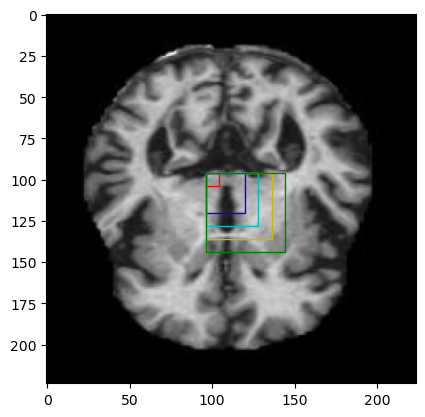

In [232]:
#visualize different cell sizes against an mri scan
import matplotlib.patches as patches

fig, ax = plt.subplots()

ax.imshow(alz_images_train[0], cmap='gray')
patch1 = patches.Rectangle((96, 96), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
patch2 = patches.Rectangle((96, 96), 24, 24, linewidth=1, edgecolor='b', facecolor='none')
patch3 = patches.Rectangle((96, 96), 32, 32, linewidth=1, edgecolor='c', facecolor='none')
patch4 = patches.Rectangle((96, 96), 40, 40, linewidth=1, edgecolor='y', facecolor='none')
patch5 = patches.Rectangle((96, 96), 48, 48, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)
ax.add_patch(patch5)
plt.show

In [233]:
#function that extracts HOG features based on input parameters
def HOG_extractor(data=[], 
                  orientations = 15,
                  pixels_per_cell = (40,40), 
                  cells_per_block = (6,6)):
    
    hog_data = []
    for i in range (0, len(data)):
        hog_data.append(hog(data[i], orientations = orientations, 
                        pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block))
        
    
    return hog_data


In [236]:
#Evaluate whether RFC performs better with HOG feature extraction, and HOG feature extraction +equalize 


def HOG_RFC_evaluate(
    train =[], train_label= [], 
    test=[], test_label = [],
    
    #Equalization Flag
    use_Equalize = False,
    
    #HOG parameters
    orientations = [21], cellSize = [(32,32)], blockSize = [(7,7)],
    
    #RFC parameters
    n_estimators=[1000], 
    max_depth=[20],
    use_cw = False): 
    
    NumHOGParam = len(orientations)*len(cellSize)*len(blockSize)
    summary = pd.DataFrame(columns=['Equalization', 'Orientations', 'Cell Size', 'Block Size', 'Val Accuracy'])
    RFC_performance = []

    id1 = 0
    id2 = 0
    id3 = 0
    
    #Prepare Train and Test Data for HOG feature extraction
    
    images_train = np.copy(alz_images_train)
    images_test = np.copy(alz_images_test)
    
    #Equalize images first before HOG feature extraction, if flag is True
    if(use_Equalize == True):
        images_train = equalizeImage(images_train)
        images_test = equalizeImage(images_test)

        
        
    #check HOG input size
    #print("HOG Debug1 , train shape: ", np.array(images_train).shape)
    #print("HOG debug2 , test shape: ", np.array(images_test).shape)
            
    #Evaluate RFC performance per HOG hyperparameter combination    

    for i in range(0, NumHOGParam):
    
        #print("indexes: ", id1, id2, id3)
        
        HOG_train = HOG_extractor(images_train, orientations = orientations[id1],
                              pixels_per_cell = cellSize[id2],
                              cells_per_block = blockSize[id3])

        HOG_test  = HOG_extractor(images_test, orientations = orientations[id1],
                              pixels_per_cell = cellSize[id2],
                              cells_per_block = blockSize[id3])
    
    

        #print("\tHOG conversion done")
        #print("\tHOG train shape: ", np.array(HOG_train).shape)
        #print("\tHOG test shape: ", np.array(HOG_test).shape)
    
        summary.at[i, 'Equalization'] = use_Equalize
        summary.at[i, 'Orientations'] = orientations[id1]
        summary.at[i, 'Cell Size'] = cellSize[id2]
        summary.at[i, 'Block Size'] = blockSize[id3]
    
        #update index
    
        if((id2 == len(np.array(cellSize))-1) & (id3 == len(np.array(blockSize)) - 1 )) : id1 = (id1 + 1)%len(np.array(orientations))
        if(id3 == len(np.array(blockSize)) - 1 ) : id2 = (id2 + 1)%len(np.array(cellSize))
        id3 = (id3 + 1)%len(np.array(blockSize)) #always increment by 1 per iteration

        #skip model fitting/evaluation if HOG doesnt return any features
        if(np.array(HOG_train[0]).shape ==(0,)): 
            RFC_performance.append([])
            continue
    
        #evaluate RFC
        performance = RFC_evaluate(train = HOG_train, train_label = alz_labels_train,
                               test = HOG_test, test_label = alz_labels_test,
                               n_estimators = n_estimators, max_depth = max_depth,
                               use_cw = use_cw)
        
        #print HOG debug
        print("i: ", i)
        print("Summary:\n", summary)
        print("RFC Performance:\n", performance)
    
        
        RFC_performance.append(performance)
    
    
    return summary, RFC_performance
    
    



In [238]:
#HOG parameters to try
orientations = [15, 21, 24] #the number of edge orientations each 'cell' is going to be converted to.
cellSize = [(32,32)] #in pixels
blockSize = [(7,7)] #in cells, used in normalization

#RFC parameters to try
n_estimators = [1500]
max_depth = [20]

#Evaluate RFC with HOG
hog_features, RFC_performance = HOG_RFC_evaluate(
    train =alz_images_train, train_label= alz_labels_test, 
    test=alz_images_test, test_label = alz_labels_test,
    
    #Equalization Flag
    use_Equalize = False,
    
    #HOG parameters
    orientations = orientations, cellSize = cellSize, blockSize = blockSize,
    
    #RFC parameters
    n_estimators=n_estimators, 
    max_depth=max_depth,
    use_cw = False)

i:  0
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val Accuracy
0       1500        20  0:01:43.675115               1.0     0.636435
i:  1
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
1        False           21  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val Accuracy
0       1500        20  0:02:02.601110               1.0     0.618452
i:  2
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
1        False           21  (32, 32)     (7, 7)          NaN
2        False           24  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val

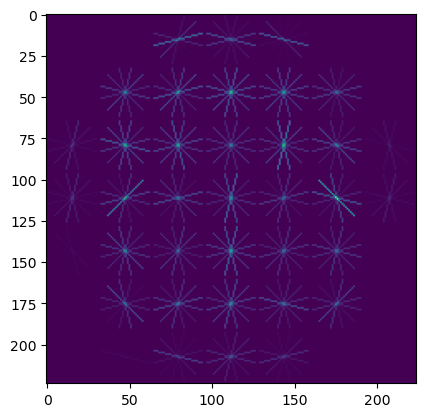

In [119]:
#HOG image visualization for alz_images_train[0]
#cell size is 32x32 pixels
#block size is 7x7 cells

In [568]:
#RNN
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

tf.random.set_seed(99)

In [569]:
#Convert labels to integer values as required by Keras 
labels_train_int = np.copy(alz_labels_train)
labels_train_int[labels_train_int=='MildDemented']=0
labels_train_int[labels_train_int=='ModerateDemented']=1
labels_train_int[labels_train_int=='NonDemented']=2
labels_train_int[labels_train_int=='VeryMildDemented']=3
labels_train_int = labels_train_int.astype(int)

labels_test_int = np.copy(alz_labels_test)
labels_test_int[labels_test_int=='MildDemented']=0
labels_test_int[labels_test_int=='ModerateDemented']=1
labels_test_int[labels_test_int=='NonDemented']=2
labels_test_int[labels_test_int=='VeryMildDemented']=3
labels_test_int = labels_test_int.astype(int)

In [570]:
#compute class_weights due to data imbalance
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(labels_train_int), 
                                     y = labels_train_int)

class_weights = dict(zip(np.unique(labels_train_int), class_weights))
class_weights

{0: 1.7855648535564854,
 1: 24.620192307692307,
 2: 0.50009765625,
 3: 0.7144252232142857}

In [571]:
# create checkpoint to save best RNN model to a file depending on "val_accuracy"
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [572]:
%%time
# Initialize/compile/train RNN Model (Keras provides three different RNN algorithms - Simple RNN, LSTM, and GRU)
# Case 1. With Class_Weight, hyperparameter is epoch

model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

#train RNN using 150 epochs, and save the best model to a file for evaluation 
trainer=model.fit(np.array(alz_images_train), np.array(labels_train_int),
                  validation_data=(np.array(alz_images_test), np.array(labels_test_int)), 
                  epochs=150,
                  class_weight = class_weights,
                  callbacks=[model_checkpoint_callback])



Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_55 (GRU)                    │ (None, 128)            │       135,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,964 (535.02 KB)

 Trainable params: 136,708 (534.02 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.1162 - loss: 1.5013 - val_accuracy: 0.5004 - val_loss: 1.2787
Epoch 2/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.3574 - loss: 1.4344 - val_accuracy: 0.1400 - val_loss: 1.3013
Epoch 3/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.4008 - loss: 1.2338 - val_accuracy: 0.5004 - val_loss: 1.9206
Epoch 4/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.4247 - loss: 1.1556 - val_accuracy: 0.5004 - val_loss: 1.7809
Epoch 5/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.4530 - loss: 1.0046 - val_accuracy: 0.4816 - val_loss: 1.0802
Epoch 6/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.4774 - loss: 0.9157 - val_accuracy: 0.3339 - val_loss: 1.5758
Epoch 7/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.4761 - loss: 0.8986 - val_accuracy: 0.4097 - val_loss: 1.2634
Epoch 8/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.5241 -

161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9799 - loss: 0.0383 - val_accuracy: 0.6380 - val_loss: 2.8941
Epoch 51/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9800 - loss: 0.0404 - val_accuracy: 0.6286 - val_loss: 3.4203
Epoch 52/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9872 - loss: 0.0246 - val_accuracy: 0.5489 - val_loss: 4.3717
Epoch 53/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9950 - loss: 0.0110 - val_accuracy: 0.6740 - val_loss: 2.8151
Epoch 54/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9826 - loss: 0.0294 - val_accuracy: 0.5496 - val_loss: 3.4001
Epoch 55/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9459 - loss: 0.1064 - val_accuracy: 0.6802 - val_loss: 2.1227
Epoch 56/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9803 - loss: 0.0416 - val_accuracy: 0.5207 - val_loss: 4.1630
Epoch 57/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9880 - loss

Epoch 99/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9888 - loss: 0.0217 - val_accuracy: 0.3135 - val_loss: 10.8847
Epoch 100/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8806 - loss: 0.2661 - val_accuracy: 0.5989 - val_loss: 3.3976
Epoch 101/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9825 - loss: 0.0433 - val_accuracy: 0.5199 - val_loss: 4.1625
Epoch 102/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9964 - loss: 0.0136 - val_accuracy: 0.6200 - val_loss: 2.6736
Epoch 103/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.6615 - val_loss: 2.3211
Epoch 104/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.6857 - val_loss: 2.4690
Epoch 105/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9991 - loss: 0.0022 - val_accuracy: 0.6888 - val_loss: 2.4491
Epoch 106/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - ac

161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9741 - loss: 0.0501 - val_accuracy: 0.5012 - val_loss: 5.5631
Epoch 148/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9857 - loss: 0.0261 - val_accuracy: 0.5872 - val_loss: 4.0525
Epoch 149/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9920 - loss: 0.0145 - val_accuracy: 0.3839 - val_loss: 7.2084
Epoch 150/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9875 - loss: 0.0264 - val_accuracy: 0.4848 - val_loss: 6.5786
CPU times: user 1h 5min 52s, sys: 19min 12s, total: 1h 25min 4s
Wall time: 51min 50s


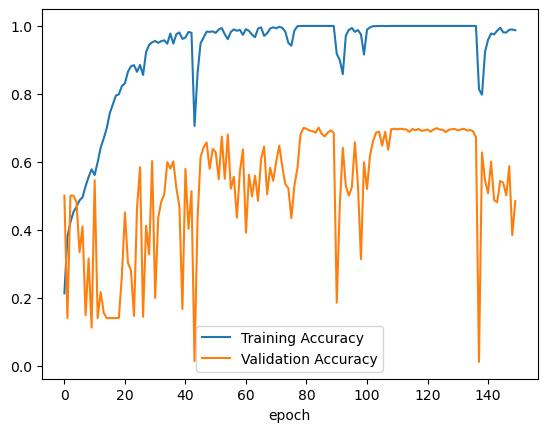

In [573]:
# Training and Validation Accuracy vs Epoch
plt.plot(trainer.history['accuracy'], label='Training Accuracy')
plt.plot(trainer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("epoch")
plt.legend()

In [574]:
#Max Accuracy
print(np.max(trainer.history['val_accuracy']))

0.7005472779273987


In [575]:
#Load Best Model and generate classification report
#model = tf.keras.saving.load_model(filepath = checkpoint_filepath)
best_model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
best_model.load_weights(checkpoint_filepath)

#print classification report for best model
y_pred = best_model.predict(np.array(alz_images_test))
labels_pred = np.argmax(y_pred, axis=1)
print(classification_report(labels_test_int, labels_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
              precision    recall  f1-score   support

           0       0.69      0.47      0.56       179
           1       1.00      0.33      0.50        12
           2       0.72      0.83      0.77       640
           3       0.67      0.62      0.64       448

    accuracy                           0.70      1279
   macro avg       0.77      0.56      0.62      1279
weighted avg       0.70      0.70      0.69      1279



In [561]:
#CASE 2. Train with NO Class Weight

#Save best model for no class_weight adjustments
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel_NoCW.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

model2 = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)),
          tf.keras.layers.GRU(128),
          tf.keras.layers.BatchNormalization(),
          #tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')])


model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model2.summary()

trainer2=model2.fit(np.array(alz_images_train), np.array(labels_train_int),
                  validation_data=(np.array(alz_images_test), np.array(labels_test_int)), 
                  epochs=150,
                  #class_weight = class_weights1
                  callbacks=[model_checkpoint_callback])



Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_50 (GRU)                    │ (None, 128)            │       135,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,964 (535.02 KB)

 Trainable params: 136,708 (534.02 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.4797 - loss: 1.2045 - val_accuracy: 0.5004 - val_loss: 1.0432
Epoch 2/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.5327 - loss: 0.9788 - val_accuracy: 0.3964 - val_loss: 1.0487
Epoch 3/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.5798 - loss: 0.8978 - val_accuracy: 0.5027 - val_loss: 1.0509
Epoch 4/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.6259 - loss: 0.8364 - val_accuracy: 0.3855 - val_loss: 1.2255
Epoch 5/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.6380 - loss: 0.7902 - val_accuracy: 0.1407 - val_loss: 3.7760
Epoch 6/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.6753 - loss: 0.7419 - val_accuracy: 0.1400 - val_loss: 9.0808
Epoch 7/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.7041 - loss: 0.6884 - val_accuracy: 0.1400 - val_loss: 12.6442
Epoch 8/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7381 

161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.5262 - val_loss: 4.4827
Epoch 51/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9773 - loss: 0.0582 - val_accuracy: 0.6067 - val_loss: 2.8212
Epoch 52/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9865 - loss: 0.0366 - val_accuracy: 0.5285 - val_loss: 4.9358
Epoch 53/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9923 - loss: 0.0233 - val_accuracy: 0.3972 - val_loss: 7.7316
Epoch 54/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9906 - loss: 0.0233 - val_accuracy: 0.6575 - val_loss: 2.1698
Epoch 55/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9771 - loss: 0.0867 - val_accuracy: 0.5723 - val_loss: 2.7731
Epoch 56/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9961 - loss: 0.0154 - val_accuracy: 0.5090 - val_loss: 5.1169
Epoch 57/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9974 - loss

161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 1.0000 - loss: 1.7193e-07 - val_accuracy: 0.6818 - val_loss: 5.4410
Epoch 146/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 1.0000 - loss: 1.7712e-07 - val_accuracy: 0.6912 - val_loss: 5.1697
Epoch 147/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 1.0000 - loss: 1.3342e-07 - val_accuracy: 0.6888 - val_loss: 5.4974
Epoch 148/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 1.0000 - loss: 1.2917e-07 - val_accuracy: 0.6888 - val_loss: 5.0296
Epoch 149/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 1.0000 - loss: 2.2805e-07 - val_accuracy: 0.6724 - val_loss: 5.9104
Epoch 150/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 1.0000 - loss: 1.7755e-07 - val_accuracy: 0.6779 - val_loss: 5.9406


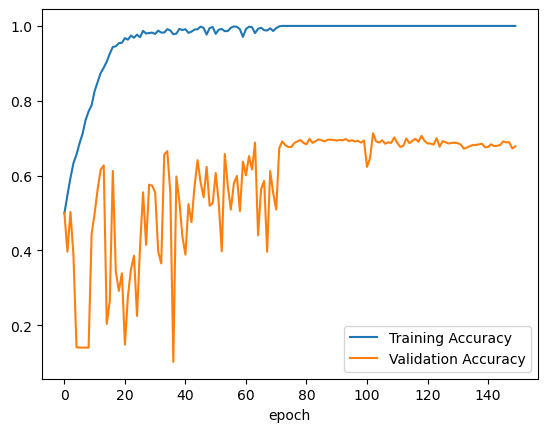

0.7130571007728577


In [562]:
# Training and Validation Accuracy vs Epoch
plt.plot(trainer2.history['accuracy'], label='Training Accuracy')
plt.plot(trainer2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#Max Accuracy
print(np.max(trainer2.history['val_accuracy']))

In [563]:
#Load Best Model for this model variation and generate classification report
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel_NoCW.keras"
best_model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
best_model.load_weights(checkpoint_filepath)

#print classification report for best model
y_pred = best_model.predict(np.array(alz_images_test))
labels_pred = np.argmax(y_pred, axis=1)
print(classification_report(labels_test_int, labels_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       179
           1       0.62      0.42      0.50        12
           2       0.75      0.82      0.79       640
           3       0.67      0.65      0.66       448

    accuracy                           0.71      1279
   macro avg       0.68      0.60      0.63      1279
weighted avg       0.71      0.71      0.71      1279

